In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from IPython.display import Markdown, display
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.preprocessing import label_binarize, StandardScaler
from scipy.stats import norm
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import KMeans, DBSCAN
import warnings 
warnings.filterwarnings('ignore')


def printmd(string):
    display(Markdown(string))

pd.options.display.float_format = '{:.4f}'.format


In [4]:
from FCG.Optika import Optika
    


In [5]:
df = pd.read_csv("credit_train.csv")


In [6]:
#Preprocessing data

df["Loan Status"].map({"Fully Paid": 1, "Charged Off": 0})
df.drop_duplicates(inplace=True)
na = df[df['Loan ID'].isnull()].index.tolist()
df.drop(na, inplace=True)
df = df.drop(['Months since last delinquent'], axis=1)
df.dropna(thresh=13, inplace=True)
mapping_dict = {
    "Years in current job": {
        "10+ years": 10,
        "9 years": 9,
        "8 years": 8,
        "7 years": 7,
        "6 years": 6,
        "5 years": 5,
        "4 years": 4,
        "3 years": 3,
        "2 years": 2,
        "1 year": 1,
        "< 1 year": 0
    }
}

df.replace(mapping_dict, inplace=True)
df["Years in current job"].fillna(0, inplace=True)

In [7]:
#Splitting the columns to numerical and category
category_cols = df.select_dtypes(include=['object']).columns # DOOBI: typo - category_cols
for col in category_cols:
    df[col] = df[col].astype('category')
    df[col].fillna(df[col].mode()[0], inplace=True)
    df[col] = df[col].cat.codes 
numeric_cols = df.select_dtypes(include=['int64','float64']).columns 
for col in numeric_cols:
    df[col].fillna(df[col].mean(), inplace=True)
info_cols = ['Loan ID', 'Customer ID']

In [8]:
df.head()

,Loan ID,Customer ID,Loan Status,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
0,6697,48724,1,445412.0000,1,709.0000,1167493.0000,8.0000,1,5,5214.7400,17.2000,6.0000,1.0000,228190.0000,416746.0000,1.0000,0.0000
1,23041,14688,1,262328.0000,1,1130.8306,1375894.3877,10.0000,1,3,33295.9800,21.1000,35.0000,0.0000,229976.0000,850784.0000,0.0000,0.0000
2,25441,30541,1,99999999.0000,1,741.0000,2231892.0000,8.0000,2,3,29200.5300,14.9000,18.0000,1.0000,297996.0000,750090.0000,0.0000,0.0000
3,38341,74173,1,347666.0000,0,721.0000,806949.0000,3.0000,2,3,8741.9000,12.0000,9.0000,0.0000,256329.0000,386958.0000,0.0000,0.0000
4,68058,41470,1,176220.0000,1,1130.8306,1375894.3877,5.0000,3,3,20639.7000,6.1000,15.0000,0.0000,253460.0000,427174.0000,0.0000,0.0000


In [9]:
X = df.drop("Loan Status", axis=1).drop(info_cols, axis = 1)
y = df["Loan Status"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

THE MODEL

Here we use the logistic regression for the example but the method is model-agnostic so you can use any model

In [10]:

log_reg = LogisticRegression()
log_reg = log_reg.fit(X_train, y_train)
log_reg_pred = log_reg.predict(X_test)


Configuration

The customer is able to fix features to be fixed and features to be changed in the configuration

In [11]:
config = {"features_to_change": ['Current Loan Amount', 'Term', 'Credit Score',
                                 'Annual Income', 'Years in current job', 'Home Ownership', 'Purpose',
                                 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts'],
          "increase_features": ['Credit Score', 'Annual Income'],
          "categorical columns": list(category_cols),
          "numerical columns" : list(numeric_cols),
          "n_counerfactuals": 1,
          "max_features_to_change": 2,
          "ID": 'Loan ID',
          "target": 'Loan Status'}


The instance

'obs' is the instance for which we find the counterfactual

In [12]:
obs = X.loc[[52872,]]
obs

,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
52872,98340.0000,0,6840.0000,1222954.0000,4.0000,1,9,10619.2900,13.5000,7.0000,0.0000,523450.0000,1005158.0000,0.0000,0.0000


In [13]:
y.loc[[52872,]]


52872    0
Name: Loan Status, dtype: int8

In this notebook we demonstrate the Optika module

In [14]:
op = Optika(pd.concat([X,y], axis = 1), log_reg, config, target_class=1)

STEP 1: 

we consider only the part of the dataset with features from the configuration that are NOT to be changed.

In this case the values of these features are the same as in the instance observation.

In [15]:
idx_box = op.box(obs, 1000)
len(idx_box)

2000

In [16]:
52872 in idx_box

True

STEP 2: Standartize the data

In [17]:
X_st, y, obs_st = op.pre_process(obs)

In [18]:
y.value_counts()

1    1569
0     431
Name: Loan Status, dtype: int64

In [19]:
obs_st

,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
52872,-0.3893,-1.6669,4.0973,-0.1561,-0.4346,-0.9774,2.3183,-0.6404,-0.6750,-0.8248,-0.3451,0.6163,0.0261,-0.3324,-0.1121


In [20]:
obs_st.shape

(1, 15)

STEP 3: 

Use the method for the initial estimate. 

This could be decision tree, regression or PCA.

The main achievement of this step - to choose the features to vary from the whole list of features to be changed. 

Because we are interested in the solution that is restricted in the number of features to be changed. 

So we have to choose the most important features at this step.

1. Decision Tree


In [21]:
X_gen, y_gen = op.generate_uniform_points(obs_st, 1500, 10)

In [22]:
ftrs, ftrs_, thrs = op.find_feature_importance_tree(X_gen, y_gen)
ftrs, ftrs_, thrs 

(['Credit Score', 'Bankruptcies'],
 Index(['Current Loan Amount', 'Term', 'Annual Income', 'Years in current job',
        'Home Ownership', 'Purpose', 'Monthly Debt', 'Years of Credit History',
        'Number of Open Accounts', 'Number of Credit Problems',
        'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens'],
       dtype='object'),
 [0.011205170114408247, 9.530780792236328])

2. Regression

In [60]:
features_to_use = op.find_feature_importance_regression()

In [61]:
op.features_to_use

['Credit Score', 'Current Loan Amount']

The PICTURE 

In [28]:
a,b = op.features_to_use[:2]
a,b


('Credit Score', 'Bankruptcies')

In [24]:
op.features_to_fix

Index(['Current Loan Amount', 'Term', 'Annual Income', 'Years in current job',
       'Home Ownership', 'Purpose', 'Monthly Debt', 'Years of Credit History',
       'Number of Open Accounts', 'Number of Credit Problems',
       'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens'],
      dtype='object')

In [29]:
ox, oy = obs_st.loc[:,a].values[0], obs_st.loc[:,b].values[0]

In [26]:
slice1 = op.slicing(1, 100)
slice1

,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
43530,-0.3796,-1.6669,-0.3415,-0.4571,-1.5027,-0.9774,3.2079,-0.0248,-0.3623,-0.2247,-0.3451,0.9877,0.0266,-0.3324,-0.1121
6594,-0.3871,-1.6669,-0.2790,-0.9495,-0.7016,0.0707,1.4288,-0.7827,0.0784,-1.2249,-0.3451,0.5745,0.0287,-0.3324,-0.1121
65072,-0.3858,-1.6669,-0.2941,1.0716,-0.7016,-0.9774,3.2079,0.0083,-0.7461,-0.2247,-0.3451,-0.3693,0.0238,-0.3324,-0.1121
13001,-0.3801,-1.6669,0.0000,0.0000,-1.5027,-0.9774,0.9840,-0.3487,-0.1491,0.3754,-0.3451,0.8048,0.0274,-0.3324,-0.1121
26847,-0.3790,-1.6669,-0.2762,0.5498,0.0995,-0.9774,0.5392,-0.8513,-0.1917,-0.2247,-0.3451,0.0413,0.0275,-0.3324,-0.1121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17040,-0.3761,0.5999,-0.2841,0.0159,-1.5027,-0.9774,0.5392,-1.1185,-1.2152,-0.4247,-0.3451,-0.3787,0.0225,-0.3324,-0.1121
50295,-0.3844,0.5999,0.0000,0.0000,-0.9686,-0.9774,0.5392,-0.7360,-0.6893,-0.0247,-0.3451,-0.7739,0.0242,-0.3324,-0.1121
66405,-0.3899,0.5999,-0.2783,0.2788,-1.2357,-0.9774,0.5392,-0.5303,-1.0162,0.1754,-0.3451,-0.3656,0.0273,-0.3324,-0.1121
26311,-0.3725,-1.6669,0.0000,0.0000,1.1677,-0.9774,-0.3503,0.4257,-0.5329,-0.6248,-0.3451,1.1911,0.0264,-0.3324,-0.1121


In [27]:
slice0 = op.slicing(0, 100)
slice0


,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
52872,-0.3893,-1.6669,4.0973,-0.1561,-0.4346,-0.9774,2.3183,-0.6404,-0.6750,-0.8248,-0.3451,0.6163,0.0261,-0.3324,-0.1121
98015,-0.3777,-1.6669,3.8174,-0.2159,-1.5027,-0.9774,3.2079,-0.0448,-0.3623,1.1756,-0.3451,0.5780,0.0243,-0.3324,-0.1121
56980,-0.3887,-1.6669,4.2623,0.3210,-1.5027,-0.9774,3.2079,1.2921,-0.6324,-0.0247,-0.3451,1.2984,0.0276,-0.3324,-0.1121
51075,-0.3692,-1.6669,4.1044,-0.0482,0.6336,0.0707,-0.3503,0.1992,-0.0069,-1.2249,-0.3451,0.9121,0.0279,-0.3324,-0.1121
37953,-0.3720,-1.6669,4.3484,0.6624,0.0995,-0.9774,-0.3503,0.5972,0.2916,-0.6248,-0.3451,1.0923,0.0255,-0.3324,-0.1121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59829,-0.3692,-1.6669,4.2408,1.3042,1.1677,-0.9774,-0.3503,3.8570,1.0308,0.7755,-0.3451,0.6957,0.0290,-0.3324,-0.1121
8365,-0.3826,0.5999,4.5207,-0.6817,1.1677,1.1189,-0.3503,-0.4024,1.5852,2.7760,-0.3451,-0.0950,0.0227,-0.3324,-0.1121
28632,-0.3722,-1.6669,3.8174,1.7376,-0.1675,-0.9774,0.5392,3.1747,1.1019,2.9760,-0.3451,1.3583,0.0290,-0.3324,-0.1121
70856,-0.3859,0.5999,4.4130,-0.2398,1.1677,-0.9774,-1.6847,-0.5049,1.8980,-0.2247,1.7469,0.0783,0.0243,-0.3324,3.8080


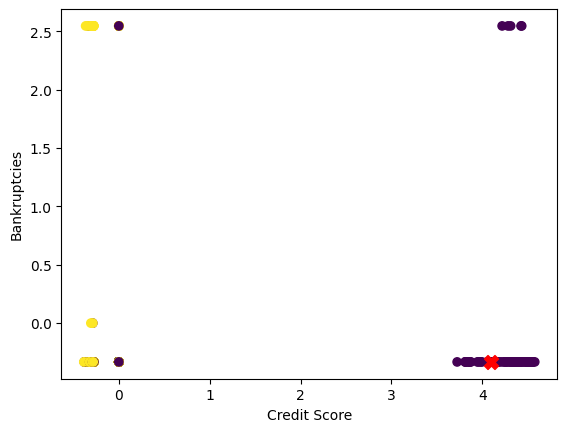

In [30]:
plt.figure()
plt.scatter(x = X_st[a],y = X_st[b],  c= y, cmap = 'viridis')
plt.scatter(x = obs_st[a], y = obs_st[b], c='red', marker='X', s = 100)
plt.xlabel(a)
plt.ylabel(b)

#X_st.plot.scatter(x = 'Current Loan Amount',y = 'Credit Score',  c= y, cmap = 'viridis')
#obs_st.plot.scatter(x = 'Current Loan Amount', y = 'Credit Score', c='red', marker='X', s = 100)
plt.show()

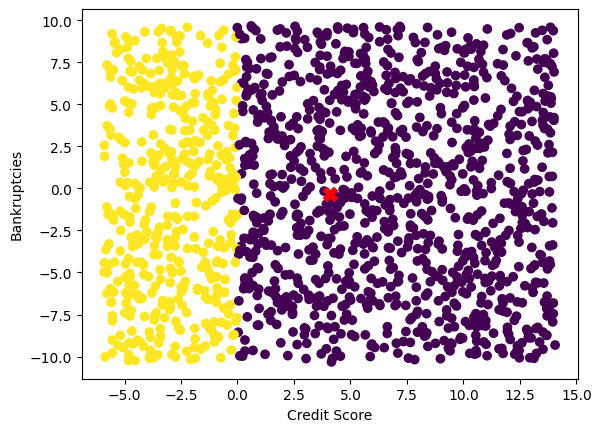

In [31]:
plt.figure()
plt.scatter(x = X_gen[a],y = X_gen[b],  c= y_gen, cmap = 'viridis')
plt.scatter(x = obs_st[a], y = obs_st[b], c='red', marker='X', s = 100)
plt.xlabel(a)
plt.ylabel(b)
plt.show()

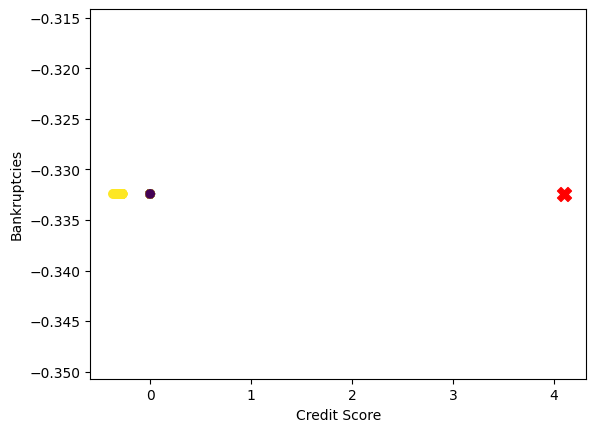

In [32]:
plt.figure()
plt.scatter(x = slice1[a],y = slice1[b],  c= log_reg.predict(slice1), cmap = 'viridis')
plt.scatter(x = obs_st[a], y = obs_st[b], c='red', marker='X', s = 100)
plt.xlabel(a)
plt.ylabel(b)
plt.show()

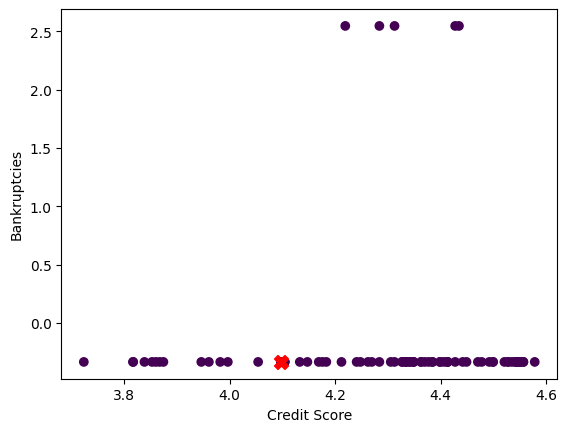

In [33]:
plt.figure()
plt.scatter(x = slice0[a],y = slice0[b],  c= log_reg.predict(slice0), cmap = 'viridis')
plt.scatter(x = obs_st[a], y = obs_st[b], c='red', marker='X', s = 100)
plt.xlabel(a)
plt.ylabel(b)
plt.show()

STEP 4

At this final step you can use various methods for search. 

Binary search ...

Weitzfeld algorythm - minimizes the weighted sum of distances from the counterfactual to the instance and nearest datapoints in the target class. We use the second term as the proxie for density in around the counterfactual in the target class.

Weber algorythm - minimizes the weighted sum of distances from the counterfactual to the instance and nearest datapoints in the target class substraced with weighted sum of distances to the nearest datapoints from the opposite class. We use the second term as the proxie for density around the counterfactual in the target class and  the third term as the proxie for density around the counterfactual in the antitarget class.

In [34]:
# Slice the data - choose 100 points in the unstances's neighborhood accounting for fixed features

slice = op.slicing(1,100)
slice

,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
43530,-0.3796,-1.6669,-0.3415,-0.4571,-1.5027,-0.9774,3.2079,-0.0248,-0.3623,-0.2247,-0.3451,0.9877,0.0266,-0.3324,-0.1121
6594,-0.3871,-1.6669,-0.2790,-0.9495,-0.7016,0.0707,1.4288,-0.7827,0.0784,-1.2249,-0.3451,0.5745,0.0287,-0.3324,-0.1121
65072,-0.3858,-1.6669,-0.2941,1.0716,-0.7016,-0.9774,3.2079,0.0083,-0.7461,-0.2247,-0.3451,-0.3693,0.0238,-0.3324,-0.1121
13001,-0.3801,-1.6669,0.0000,0.0000,-1.5027,-0.9774,0.9840,-0.3487,-0.1491,0.3754,-0.3451,0.8048,0.0274,-0.3324,-0.1121
26847,-0.3790,-1.6669,-0.2762,0.5498,0.0995,-0.9774,0.5392,-0.8513,-0.1917,-0.2247,-0.3451,0.0413,0.0275,-0.3324,-0.1121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17040,-0.3761,0.5999,-0.2841,0.0159,-1.5027,-0.9774,0.5392,-1.1185,-1.2152,-0.4247,-0.3451,-0.3787,0.0225,-0.3324,-0.1121
50295,-0.3844,0.5999,0.0000,0.0000,-0.9686,-0.9774,0.5392,-0.7360,-0.6893,-0.0247,-0.3451,-0.7739,0.0242,-0.3324,-0.1121
66405,-0.3899,0.5999,-0.2783,0.2788,-1.2357,-0.9774,0.5392,-0.5303,-1.0162,0.1754,-0.3451,-0.3656,0.0273,-0.3324,-0.1121
26311,-0.3725,-1.6669,0.0000,0.0000,1.1677,-0.9774,-0.3503,0.4257,-0.5329,-0.6248,-0.3451,1.1911,0.0264,-0.3324,-0.1121


In [40]:
op.features_to_use

['Credit Score', 'Bankruptcies']

In [41]:
op.thresholds

[0.011205170114408247, 9.530780792236328]

In [37]:
w = [0.5, 0.1]  #weights for weitzfeld algorythm


In [38]:
obs_st

,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
52872,-0.3893,-1.6669,4.0973,-0.1561,-0.4346,-0.9774,2.3183,-0.6404,-0.6750,-0.8248,-0.3451,0.6163,0.0261,-0.3324,-0.1121


Weitzfeld algorythm

In [42]:
# op.thresholds give us the initial position from step 3
# 5 - the number of neighbors we account for in the target class

c,d = op.weitzfeld(op.thresholds, w, 5)

In [49]:
cand_obs = obs_st.copy()
cand_obs[op.features_to_use] = op.thresholds
cand_obs

,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
52872,-0.3893,-1.6669,0.0112,-0.1561,-0.4346,-0.9774,2.3183,-0.6404,-0.6750,-0.8248,-0.3451,0.6163,0.0261,9.5308,-0.1121


In [43]:
d

10.676072443775919

In [46]:
c

,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
0,-0.3893,-1.6669,0.0112,-0.1561,-0.4346,-0.9774,2.3183,-0.6404,-0.6750,-0.8248,-0.3451,0.6163,0.0261,9.5308,-0.1121


In [50]:
# check - here the search is unlucky, so it is necessary to choose another initial estimate
log_reg.predict(cand_obs)

array([0], dtype=int8)

Beeswarm

In [51]:
w = [0.7, 0.3, 0.1]  
#0.7 - inertia weight, 0.3 the attraction weight for density in the target class, 
# 0.1 - the repulsion weight for density in the antitarget class


In [53]:
# Define the number of agents and the number of dimensions
num_agents = 3
num_dimensions = len(op.features_to_use)
w = [0.7, 0.2, 0.2, 0.2, -0.1, -0.1, -0.1]

# Define the number of iterations and the PSO parameters
num_iterations = 3
inertia_weight = 0.7
cognitive_weight = 0.2
social_weight = 0.1

In [54]:
obs_st

,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
52872,-0.3893,-1.6669,4.0973,-0.1561,-0.4346,-0.9774,2.3183,-0.6404,-0.6750,-0.8248,-0.3451,0.6163,0.0261,-0.3324,-0.1121


In [55]:
op.thresholds

[0.011205170114408247, 9.530780792236328]

In [56]:
#best_obs, best_dist, glob_dist, pos = 
cfs, dist = op.beeswarm(obs_st, op.features_to_use, op.thresholds, w)

ITERATION   0
best [-7.16630904  2.67174287]
__________________________________________
ITERATION   1
best [-7.16630904  2.67174287]
__________________________________________
ITERATION   2
best [-7.16630904  2.67174287]
__________________________________________
ITERATION   3
best [-7.16630904  2.67174287]
__________________________________________
ITERATION   4
best [-1.85790119 -1.85790119]
__________________________________________


In [57]:
dist

5.210748992959686

In [58]:
cfs

,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
52872,-0.3893,-1.6669,-1.8579,-0.1561,-0.4346,-0.9774,2.3183,-0.6404,-0.6750,-0.8248,-0.3451,0.6163,0.0261,-1.8579,-0.1121


In [59]:
log_reg.predict(cfs)

array([1], dtype=int8)

In [62]:
%%time


UsageError: %%time is a cell magic, but the cell body is empty. Did you mean the line magic %time (single %)?


DISTANCE

In [63]:

a = obs_st.copy().reset_index(drop = True)




In [64]:
dist_obs = euclidean_distances(obs_st, a)

In [65]:
nbrs = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(X_st)


In [66]:
radius = nbrs.kneighbors(a, return_distance = True)[0][0]
centers = nbrs.kneighbors(a, return_distance = True)[1][0]

In [151]:
radius

array([1.76554572, 1.84949056, 2.05334973, 2.18717947, 2.2352472 ])

In [156]:
centers.tolist()

[658, 1622, 1907, 1217, 583]

In [164]:
X_st.iloc[centers]

,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
43530,-0.38,-1.67,-0.34,-0.46,-1.50,-0.98,3.21,-0.02,-0.36,-0.22,-0.35,0.99,0.03,-0.33,-0.11
6594,-0.39,-1.67,-0.28,-0.95,-0.70,0.07,1.43,-0.78,0.08,-1.22,-0.35,0.57,0.03,-0.33,-0.11
65072,-0.39,-1.67,-0.29,1.07,-0.70,-0.98,3.21,0.01,-0.75,-0.22,-0.35,-0.37,0.02,-0.33,-0.11
13001,-0.38,-1.67,0.00,0.00,-1.50,-0.98,0.98,-0.35,-0.15,0.38,-0.35,0.80,0.03,-0.33,-0.11
26847,-0.38,-1.67,-0.28,0.55,0.10,-0.98,0.54,-0.85,-0.19,-0.22,-0.35,0.04,0.03,-0.33,-0.11


In [98]:
a

,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
0,-0.3893,-1.6669,4.0973,-0.1561,-0.4346,-0.9774,2.3183,-0.6404,-0.6750,-0.8248,-0.3451,0.6163,0.0261,-0.3324,-0.1121


In [168]:
dist_set = euclidean_distances(a, X_st.iloc[centers])

DICE

Compare with Dice

In [84]:
dice_df = X_st.copy()
dice_df.shape

(2000, 15)

In [85]:
continuous_features = ['Current Loan Amount', 'Term', 'Credit Score',
       'Annual Income', 'Years in current job', 'Home Ownership', 'Purpose',
       'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts',
       'Number of Credit Problems', 'Current Credit Balance',
       'Maximum Open Credit', 'Bankruptcies', 'Tax Liens']

In [71]:
y = df["Loan Status"]
y

0        1
1        1
2        1
3        1
4        1
        ..
99994    1
99996    1
99997    1
99998    1
99999    1
Name: Loan Status, Length: 89785, dtype: int8

In [94]:
import dice_ml

from dice_ml.utils import helpers # helper functions 

 #Change only the features to change 
config_dice = {"features_to_change": ['Credit Score', 'Bankruptcies'],
             "n_counerfactuals": 1,  
             "target": 'Loan Status'}
m = dice_ml.Model(model=log_reg, backend='sklearn')
d = dice_ml.Data(dataframe=pd.concat([dice_df,y], axis = 1), continuous_features=list(numeric_cols), outcome_name='Loan Status', m = m)
exp = dice_ml.Dice(d, m, method='random') 

In [ ]:
import time
# Start time
start_time = time.time()
e = exp.generate_counterfactuals(dice_df, total_CFs=1, desired_class="opposite", features_to_vary=config_dice["features_to_change"])

# End time
end_time = time.time()
# Elapsed time
elapsed_time_dice = end_time - start_time
print("Time taken:", elapsed_time_dice, "seconds")


In [95]:
e = exp.generate_counterfactuals(obs_st, total_CFs=1, desired_class="opposite", features_to_vary=config_dice["features_to_change"])


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]


In [96]:
cf = e.cf_examples_list[0].final_cfs_df

In [97]:
cf

,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens,Loan Status
0,-0.3893,-1.6669,-0.0000,-0.1561,-0.4346,-0.9774,2.3183,-0.6404,-0.6750,-0.8248,-0.3451,0.6163,0.0261,1.1709,-0.1121,1


In [72]:
X_st = StandardScaler().fit_transform(X)


In [63]:
cf_st_dice = StandardScaler().transform(cf)


dist_dice = euclidean_distances(obs_st, cf_st_dice)
dist_dice

Index(['Current Loan Amount', 'Credit Score', 'Annual Income',
       'Years in current job', 'Monthly Debt', 'Years of Credit History',
       'Number of Open Accounts', 'Number of Credit Problems',
       'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies',
       'Tax Liens'],
      dtype='object')